Resources:</br>
Scikit-learn https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html</br>
20 Newsgroups original site http://qwone.com/~jason/20Newsgroups/</br>

TODO: </br>
think about document frequency for eliminating stop words(look at most frequent words)</br>
typo fixing</br>
check number relevancy</br>
try multiple preprocessings</br>
try [clean-text](https://pypi.org/project/clean-text/) library</br>
remove emails</br>
use n-grams</br>
</br>
Tunning:</br>
Upper and bottom limit for doc length</br>
min df and max df in count vectorizer</br>

## Setup

In [ ]:
!pip install Distance
!pip install spacy
!spacy download en
!pip install git+https://git@github.com/kavgan/word_cloud.git

Imports

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn import metrics
import distance
import re
import spacy
import numpy as np
from pprint import pprint
from tqdm import tqdm
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

Settings

In [ ]:
use_sub_categories = True
categories = ['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']  # must be ordered by abecede!
RANDOM_STATE = 42

Load dataset

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories = categories if use_sub_categories else None, 
                                      shuffle=True, 
                                      random_state=RANDOM_STATE)

In [ ]:
print('Number of topics: ', len(list(newsgroups_train.target_names)))
pprint(list(newsgroups_train.target_names))

Number of topics:  4
['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']


In [ ]:
pprint(list(newsgroups_train.filenames)[:5])

['/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/61193',
 '/root/scikit_learn_data/20news_home/20news-bydate-train/soc.religion.christian/20594',
 '/root/scikit_learn_data/20news_home/20news-bydate-train/soc.religion.christian/20848',
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/59848',
 '/root/scikit_learn_data/20news_home/20news-bydate-train/soc.religion.christian/21374']


In [ ]:
print(newsgroups_train.target.shape)

(2218,)


Lets see how one single document looks like

In [ ]:
index = 34
pprint(newsgroups_train.data[index])

('From: livesey@solntze.wpd.sgi.com (Jon Livesey)\n'
 'Subject: Re: <<Pompous ass\n'
 'Organization: sgi\n'
 'Lines: 20\n'
 'Distribution: world\n'
 'NNTP-Posting-Host: solntze.wpd.sgi.com\n'
 '\n'
 'In article <1qlef4INN8dn@gap.caltech.edu>, keith@cco.caltech.edu (Keith '
 'Allan Schneider) writes:\n'
 '|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:\n'
 '|> \n'
 '|> [...]\n'
 '|> >>The "`little\' things" above were in reference to Germany, clearly.  '
 'People\n'
 '|> >>said that there were similar things in Germany, but no one could name '
 'any.\n'
 "|> >That's not true.  I gave you two examples.  One was the rather\n"
 '|> >pevasive anti-semitism in German Christianity well before Hitler\n'
 '|> >arrived.  The other was the system of social ranks that were used\n'
 '|> >in Imperail Germany and Austria to distinguish Jews from the rest \n'
 '|> >of the population.\n'
 '|> \n'
 '|> These don\'t seem like "little things" to me.  At least, they are orders\n'
 '|> worse than the m

## Analysis

As showed [here](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html#newsgroups) models can easily overfit 'headers', 'footers' and 'quotes' parts of documents.</br>
In order to do topic modeling on clean text, that metadata should be removed.

In [ ]:
newsgroups_train_cleaned = fetch_20newsgroups(subset='train', 
                                              remove=('headers', 'footers', 'quotes'), 
                                              categories = categories if use_sub_categories else None,
                                              shuffle=True, 
                                              random_state=RANDOM_STATE)

Compare original and cleaned version

In [ ]:
index = 34
print('*** Topic ***')
pprint(newsgroups_train.target_names[newsgroups_train.target[index]])
print('\n*** Original ***\n')
print(newsgroups_train.data[index].strip())
print('\n*** Cleaned ***\n')
print(newsgroups_train_cleaned.data[index].strip())

*** Topic ***
'alt.atheism'

*** Original ***

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: <<Pompous ass
Organization: sgi
Lines: 20
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlef4INN8dn@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> [...]
|> >>The "`little' things" above were in reference to Germany, clearly.  People
|> >>said that there were similar things in Germany, but no one could name any.
|> >That's not true.  I gave you two examples.  One was the rather
|> >pevasive anti-semitism in German Christianity well before Hitler
|> >arrived.  The other was the system of social ranks that were used
|> >in Imperail Germany and Austria to distinguish Jews from the rest 
|> >of the population.
|> 
|> These don't seem like "little things" to me.  At least, they are orders
|> worse than the motto.  Do you think that the motto is a "little thing"
|> that will l

Investigate most frequent document length

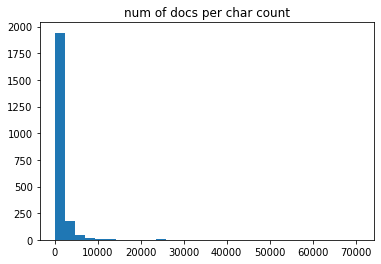

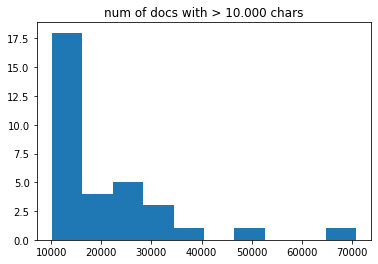

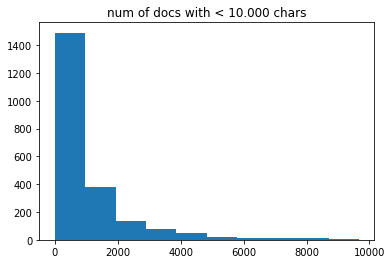

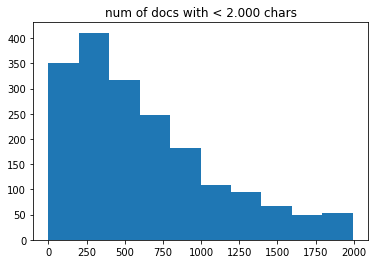

In [ ]:
lengths = [len(doc.strip()) for doc in newsgroups_train_cleaned.data]  # do not count empty lines at the begging and at the end
plt.hist(lengths, bins=30)
plt.title('num of docs per char count')
plt.show()

plt.hist(list(filter(lambda x: x > 10000, lengths)))
plt.title('num of docs with > 10.000 chars')
plt.show()

plt.hist(list(filter(lambda x: x < 10000, lengths)))
plt.title('num of docs with < 10.000 chars')
plt.show()

plt.hist(list(filter(lambda x: x < 2000, lengths)))
plt.title('num of docs with < 2.000 chars')
plt.show()

Majority of documents are short texts.</br> 
This is important conclusion in order to choose proper topic model,</br>
because some models are good only for longer documents.

Try to find empty documents and documents with a few words in it

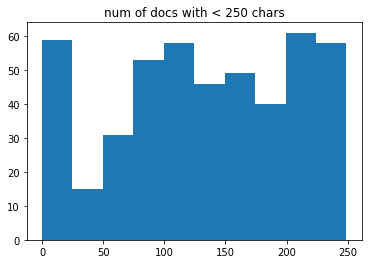

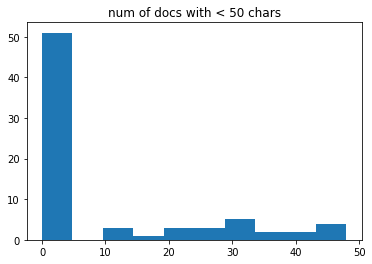

In [ ]:
plt.hist(list(filter(lambda x: x < 250, lengths)))
plt.title('num of docs with < 250 chars')
plt.show()

plt.hist(list(filter(lambda x: x < 50, lengths)))
plt.title('num of docs with < 50 chars')
plt.show()

In [ ]:
for doc in newsgroups_train_cleaned.data:
    length = len(doc.strip()) 
    if  length >= 10 and length <= 50:
        print(doc.strip())
        print('--------------------------------------------------')

I'm sold!  Where do I sign up?
--------------------------------------------------
<<<most of message deleted>>>
--------------------------------------------------
Look up "irony", Keith.
--------------------------------------------------
I AM Satan!
--------------------------------------------------
(deletion)
--------------------------------------------------
I did not claim that our system was objective.
--------------------------------------------------
Do YOU eat all your food cold?
--
--------------------------------------------------
Did you forget to put in a sarcasm flag?
--------------------------------------------------
Ahhh go back to alt.autotheism where you belong!
--------------------------------------------------
Oh, that was just a bet.
--------------------------------------------------
Sounds similar to something Wally Schirra said.
--------------------------------------------------
Thanks for the Update.
--------------------------------------------------
I'm afraid he

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=1000,  # vocabulary length
                                stop_words='english')

tf = tf_vectorizer.fit_transform(newsgroups_train_cleaned.data)
vocabulary = tf_vectorizer.get_feature_names()

In [ ]:
# pprint(tf_vectorizer.stop_words_)

In [ ]:
# dictionary with items like { term : frequency }
# pprint(tf_vectorizer.vocabulary_)

Identify similar terms in vocabulary</br>
Next cell can take a while if max_features is too high

In [ ]:
def get_similar_words(vocabulary):
    levenshtein_distance = 1
    similar_pairs = []
    vocab_len = len(vocabulary)
    for i in tqdm(range(vocab_len)):
        first = vocabulary[i]
        for j in range(i+1, vocab_len):
            second = vocabulary[j]
            if distance.levenshtein(first, second) == levenshtein_distance:
                similar_pairs.append((first, second))
    return similar_pairs

#similar_pairs = get_similar_words(vocabulary)

In [ ]:
#for first, second in similar_pairs:
#    print(first, ' ', second)

We can see a lot of numbers, and word combinations: singular-plural, present-past ... </br>
</br>
This is because CountVectorizer only does following things in preprocessing phase:</br>
* lowercases your text (set lowercase=false if you don’t want lowercasing)
* uses utf-8 encoding
* performs tokenization (removes all special characters, punctuation and single characters)
* uses word level tokenization (meaning each word is treated as a separate token)
* ignores single characters during tokenization (say goodbye to words like ‘a’ and ‘I’)
</br>

[Reference](https://kavita-ganesan.com/how-to-use-countvectorizer/#.YO7QbugzaUk)
</br>
</br>

So next step will be to do advanced preprocessing:</br>

1.   **Remove numbers** - investigate are they relevant to distinguish different topics
2.   **Lemmatize** words - in order to bring them to same base word
3.   other methods
</br>

**Stemming** is not recommended, because roots of some words 
can be less user friendly when examining words in a topic.

## Preprocessing

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
index = 34

text = newsgroups_train_cleaned.data[index]
print('*** Original ***')
print(text)

text = text.strip()
text = ' '.join(text.split())  # replace whitespace with single space
print('\n*** Normalized whitespaces ***\n')
print(text)

text = re.sub('\d', '', text)
print('\n*** Removed numbers ***\n')
print(text)

doc = nlp(text)
tokens = [token for token in doc if not token.is_stop]

print('\n*** Removed stop words ***\n')
print(' '.join([str(token) for token in tokens]))

tokens = [token.lemma_ for token in tokens]
print('\n*** Lemmatized words ***\n')
print(' '.join(tokens))

tokens = [token for token in tokens if len(token) > 1]
print('\n*** Removed single characters ***\n')
print(' '.join(tokens))

*** Original ***

You don't think these are little things because with twenty-twenty
hindsight, you know what they led to.

*** Normalized whitespaces ***

You don't think these are little things because with twenty-twenty hindsight, you know what they led to.

*** Removed numbers ***

You don't think these are little things because with twenty-twenty hindsight, you know what they led to.

*** Removed stop words ***

think little things - hindsight , know led .

*** Lemmatized words ***

think little thing - hindsight , know lead .

*** Removed single characters ***

think little thing hindsight know lead


Lets wrap this in a single method

In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.strip()
    #text = re.sub('\d', '', text)  # remove numbers 
    text = ' '.join(text.split())  # replace whitespace with single space

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token for token in tokens if len(token) > 1]

    return ' '.join(tokens)

In [ ]:
index = 343
text = newsgroups_train_cleaned.data[index]

print('*** Original ***\n')
print(text)

text = preprocess(text)

print('\n*** Preprocessed ***\n')
print(text)

*** Original ***



The name is a working name only; quite unofficial.  The formal designation
is 1993 FW.


*** Preprocessed ***

working unofficial formal designation 1993 fw


In [ ]:
preprocessed_data = [preprocess(doc) for doc in newsgroups_train_cleaned.data]

Let's fit vectorizer with preprocessed data

In [ ]:
tf_vectorizer_preprocessed = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=1000)

tf_preprocessed = tf_vectorizer_preprocessed.fit_transform(preprocessed_data)
vocabulary_preprocessed = tf_vectorizer_preprocessed.get_feature_names()

In [ ]:
index = 34
print('*** Original ***')
print(newsgroups_train_cleaned.data[index].strip())
print('\n*** Preprocessed ***')
print(preprocessed_data[index])
print('\n*** Term - Frequency ***')
non_zero_indices = np.nonzero(tf_preprocessed[index])[1]
for i in non_zero_indices:
    print(vocabulary_preprocessed[i], '-', tf_vectorizer_preprocessed.vocabulary_[vocabulary_preprocessed[i]])

*** Original ***
You don't think these are little things because with twenty-twenty
hindsight, you know what they led to.

*** Preprocessed ***
think little thing hindsight know lead

*** Term - Frequency ***
know - 478
think - 918
little - 510
thing - 917
lead - 491


Our vocabulary looks better now

In [ ]:
# pprint(tf_vectorizer_preprocessed.vocabulary_)

Word Cloud - see most occuring words per topic

In [ ]:
targets = np.array(newsgroups_train_cleaned.target)
data = np.array(preprocessed_data)

In [ ]:
# ['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']
category_name = 'talk.politics.guns'
category_index = newsgroups_train.target_names.index(category_name)
data_by_category = data[np.where(targets==category_index)]
print('category >>', categories[category_index])

category >> talk.politics.guns


In [ ]:
# can't be within same cell which contains print statement
wc=WordCloud(use_tfidf=False)
embed_code=wc.get_embed_code(text=data_by_category,random_color=False,topn=50)
HTML(embed_code)